# A Gentle (Mathematicians) Introduction to PyTorch and Neural Networks Part 02
## Gradient descent in one dimension
In this blog post, I'd like to introduce a common method used for training machine learning models such as the  [logistic model](https://linus-lach.de/posts/post-with-code/pytorch/post_01).
 This approach is commonly known as gradient descent—a method that, as its name implies, involves minimizing a function by progressively descending along its gradient.
  In the context of regression, typically a loss function such as the mean squared error is minimized, which in turn yields an optimal fit for a given model.

Mathematically speaking in its most basic form this translates into the following:\
Let $\Omega\subseteq \mathbb{R}$ and consider a function $f:\Omega \to \mathbb{R}$ that is at least one time differentiable in $\Omega$. Set an initial value $x_0\in\Omega$, a step size $\alpha \geq 0$, and iterate for $n = 0,...,N$ through the following steps:\
&nbsp; &nbsp; 1. Calculate  $d_n = -f'(x_n)$,\
&nbsp; &nbsp; 2. Set $x_{n+1} = x_{n} + \alpha d.$
After iterating through all steps, return the last value $x_N$.

The procedure above ensures that $f(x_0) \geq f(x_1) \geq ... \geq f(x_N)$ for a sufficiently small step size $\alpha$, since each $x_n$ moves along the negative gradient towards a local minimum.

## A first example
Let $f:\mathbb{R}\to\mathbb{R}, \: x\mapsto (x-2)^2$ and set $x_0 = -1,\,\alpha = 0.1, N = 20$. Then, the following interactive plot visualizes each step of the gradient descent towards the minimum at $x=2$.

In [1]:
#Some packages needed throughout the article
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
N=200
X = np.linspace(-2,6,N)
def f(x):
    return (x-2)**2

def gd_1d(epochs ,lr ,f ,x):
    coord = []
    for epoch in range(epochs):
        loss = f(x)
        coord.append([x.data,loss.data])
        loss.backward()
        x.data = x.data - lr * x.grad.data
        x.grad.data.zero_()

    return np.transpose(np.reshape(coord,(epochs,2)))
x0 = torch.tensor(-1.0,requires_grad=True)
lr = 0.1
epochs = 20
coord = gd_1d(epochs,lr,f,x0)

#Uncomment for a static version
#plt.plot(X,f(X))
#plt.plot(coord[0],coord[1],'-or')
#plt.xlim((-2,6))
#plt.ylim((-2,10))
#plt.show()


As the step size increases, $x_n$ slowly approaches the minimum at $x=0$.\
 Generally, there are quite a few pitfalls when applying gradient descent.
 Consider the function
 \begin{equation*}
 x\mapsto \frac{1}{2}*(\frac{3}{4}*x-1.2)^4-2*(\frac{3}{4}*x-1)^2+2
 \end{equation*}
 which has a global minimum at $x \approx 3.607$ and is displayed below.

As in the example before, set $x_0 = -1,\,\alpha = 0.1,$ and $N = 20$ which results in the following interactive plot.

In [3]:
def f(x):
    return 0.5*(0.75*x-1.2)**4-2*(0.75*x-1)**2+2

X = np.linspace(-2,5,N)
x0 = torch.tensor(-1.0,requires_grad=True)
lr = 0.1
epochs = 20
coord = gd_1d(epochs,lr,f,x0)

#Uncomment for a static version
#plt.plot(X,f(X))
#plt.plot(coord[0],coord[1],'-or')
#plt.xlim((-2,6))
#plt.ylim((-2,10))


It turns out that the step size is too small, so instead of approaching the global minimum at $x \approx 3.6$, the algorithm is stuck in the local minimum at $x\approx -0.1$.
This can seemingly easily be fixed by increasing the step size to $0.4$.

In [4]:
x0 = torch.tensor(-1.0,requires_grad=True)
lr = 0.40
epochs = 20
coord = gd_1d(epochs,lr,f,x0)

#Uncomment for a static version
#plt.plot(X,f(X))
#plt.plot(coord[0],coord[1],'-or')
#plt.xlim((-2,6))
#plt.ylim((-2,10))


Using a step size of $0.4$ already improves the result.
 However, for $n\geq 11$, $x_n$ is no longer approaching the global minimum rather than jumping around it from one side of the curve to the other.

## Improving the step size
So, how can an optimal step size be found? The initial change to a step size of $0.4$ seems quite arbitrary!
One way is running a grid search, where gradient descent is performed multiple times with varying step sizes.
After iterating through every step size, select the one which yields the best result.
For example, we could start with a step size of $\alpha =0.1$ and work our way up to $1.0$ with increments of $0.01$.

In [5]:
res = np.array([])
for lr in np.arange(0.1,1,0.01):
    x0 = torch.tensor(-1.0,requires_grad=True)
    epochs = 20
    coord = gd_1d(epochs,lr,f,x0)
    res = np.append(res,np.min(coord[1]))

This approach raises some new challenges, as certain step sizes cause the gradient descent to diverge. Set for example the step size to $\alpha = 0.79$ and check out what happens.

In [6]:
x0 = torch.tensor(-1.0,requires_grad=True)
lr = 0.79
epochs = 20
coord = gd_1d(epochs,lr,f,x0)

#Uncomment for a static version
#plt.plot(X,f(X))
#plt.plot(coord[0],coord[1],'-or')
#plt.xlim((-2,6))
#plt.ylim((-2,10))

By limiting ourselves to the results where $x_N$ is finite we obtain the following result.

In [7]:
opt_lr = np.arange(0.1,1,0.01)[np.argmin(res[~np.isnan(res)])+1]
x0 = torch.tensor(-1.0,requires_grad=True)
print("For a step size of {lr:.2f}, the final value for x_N is {res:.3f}".format(lr = opt_lr,res = gd_1d(epochs,opt_lr,f,x0)[0][-1]))

For a step size of 0.52, the final value for x_N is 3.613


While the final value $x_N$ is already close to the global minimum at $x \approx 3.607$, this approach is not stable at all.
Setting $N = 19$ yields a final result of $x_N \approx 2.491$, which misses the global minimum by around $1.116$. This phenomenon motivates the last part of this post.

## Variable step sizes

In this last paragraph, we discuss the so-called *Armijo--Rule*.
 It is a step size selection strategy designed to ensure that in each iteration of the gradient descent, the step size $\alpha$ is sufficiently large to make progress, and additionally to ensure that a significant decrease in the objective function value is achieved at the same time.
  By following this rule, we can address all the previous issues at once!
The basic idea for finding this optimal step size $\alpha$ in each of the $n=1,...,N$ steps of the gradient descent is outlined below.\
Set $\beta,\gamma\in(0,1)$ and define an iteration limit $M$ for the following procedure:\
For each $j = 1,...,M$:\
&nbsp; &nbsp; 1. Check if $f(x_n - \alpha  d_n) \leq f(x_n) + \gamma  \alpha  d_n^2$.\
&nbsp; &nbsp; 2. If the condition above is not fulfilled, update $\alpha$ to $\alpha\beta$.\
&nbsp; &nbsp; 3. Repeat until 1. is fulfilled or until $j=M$\
Once either one of the criteria is fulfilled, perform the next step of gradient descent with the updated $\alpha$.
By iteratively decreasing the step size $\alpha$, we ensure that the bigger jumps observed before do not occur in a neighborhood of the global minimum.

In [8]:
def gd_1d_arm(epochs ,lr ,f ,x, gamma, beta, max_iter):
    coord = []
    lr_n = lr
    for epoch in range(epochs):
        loss = f(x)
        coord.append([x.data,loss.data])
        loss.backward()
        #Armijo-Rule
        for i in range(max_iter):
            if f(x - lr_n * x.grad.data) <= f(x) + gamma * lr_n * x.grad.data**2:
                break
            lr_n *= beta
        x.data = x.data - lr_n * x.grad.data
        x.grad.data.zero_()
    return np.transpose(np.reshape(coord,(epochs,2)))

In [9]:
x0 = torch.tensor(-1.0,requires_grad=True)
lr = 1
gamma = 0.01
beta=0.5
epochs = 20
coord = gd_1d_arm(epochs,lr,f,x0,gamma,beta,max_iter=10)
#Uncomment for a static version
#plt.plot(X,f(X))
#plt.plot(coord[0],coord[1],'-or')
#plt.xlim((-2,6))
#plt.ylim((-2,10))
#plt.show()

An example of how the Armijo Rule works in detail is the following:\
In the first step of the gradient descent it holds that
\begin{equation*}
f(x_0)+\gamma\alpha d^2 \approx 3.45 \ngeq 6.05 \approx f(x_0- \alpha d).
\end{equation*}

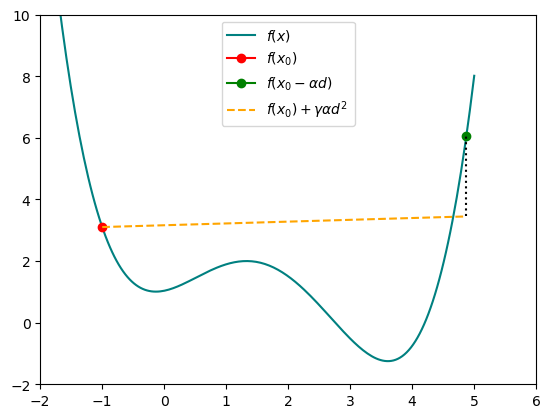

In [10]:
x0 = torch.tensor(-1.0,requires_grad=True)
f(x0).backward()

plt.plot(X,f(X),
         color = "teal",
         label = r"$f(x)$")

plt.plot(x0.detach(),f(x0.detach()),
         marker = 'o',
         color = 'red',
         label = r"$f(x_0)$")

plt.plot(x0.detach() - lr * x0.grad.data,f(x0.detach() - lr * x0.grad.data),
         marker = 'o',
         color = 'green',
         label = r"$f(x_0- \alpha d)$")
plt.plot([x0.detach(),x0.detach() - lr * x0.grad.data],[f(x0.detach())+gamma*0*x0.grad.data**2,f(x0.detach())+gamma*lr*x0.grad.data**2],
         linestyle = 'dashed',
         color = "orange",
         label = r"$f(x_0)+\gamma\alpha d^2$ ")
plt.plot([x0.detach()-lr*x0.grad.data]*2,[f(x0.detach())+gamma*lr*x0.grad.data**2,f(x0.detach() - lr * x0.grad.data)],
         linestyle = 'dotted',
         color = "black")

plt.ylim((-2,10))
plt.xlim((-2,6))
plt.legend()

Here, the orange dashed line represents the half line $\alpha \mapsto f(x_0)+\gamma\alpha d^2$ for $\alpha \in [0,1]$.
As the inequality is not yet satisfied for $\alpha = 1$, a new learning rate $\alpha = 1*0.5 = 0.5$ is applied according to the algorithm.
This results in
\begin{equation*}
f(x_0)+\gamma\alpha d^2 \approx 3.28 \geq 1.59 \approx f(x_0- \alpha d).
\end{equation*}

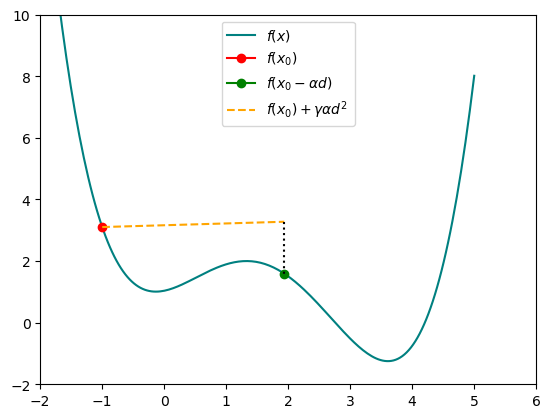

In [11]:
x0 = torch.tensor(-1.0,requires_grad=True)
f(x0).backward()

lr = lr*beta

plt.plot(X,f(X),
         color = "teal",
         label = r"$f(x)$")

plt.plot(x0.detach(),f(x0.detach()),
         marker = 'o',
         color = 'red',
         label = r"$f(x_0)$")

plt.plot(x0.detach() - lr * x0.grad.data,f(x0.detach() - lr * x0.grad.data),
         marker = 'o',
         color = 'green',
         label = r"$f(x_0- \alpha d)$")
plt.plot([x0.detach(),x0.detach() - lr * x0.grad.data],[f(x0.detach())+gamma*0*x0.grad.data**2,f(x0.detach())+gamma*lr*x0.grad.data**2],
         linestyle = 'dashed',
         color = "orange",
         label = r"$f(x_0)+\gamma\alpha d^2$ ")
plt.plot([x0.detach()-lr*x0.grad.data]*2,[f(x0.detach())+gamma*lr*x0.grad.data**2,f(x0.detach() - lr * x0.grad.data)],
         linestyle = 'dotted',
         color = "black")

plt.ylim((-2,10))
plt.xlim((-2,6))
plt.legend()

As this new learning rate satisfies the inequality, it is applied in the step of the gradient descent.\
The seemingly fruitful approach does not come without a price. By adding more variables, i.e., $\gamma$, $\beta$, and the maximum iteration number $M$, fine--tuning the algorithm gets more complicated.\
However, in most cases, there is a rule of thumb that works well for setting the initial parameters, which involves choosing $\alpha = 1$, $\beta = 0.5$, $\gamma = 0.01$, and $M=10$ to satisfy this guideline.

## Summary
In this blog post, we introduced the powerful method of gradient descent in one dimension and learned how to implement it using the `PyTorch` framework.
We discussed some common pitfalls of using gradient descent like choosing a step size $\alpha$ that is either too big or too small. In the last section we briefly introduced the Armijo--Rule which utilized a variable step size for each iteration of the gradient descent.